# We generate 2d ising configurations with one beta fixed and the other increasing with two hidden units to see a transition

In [2]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [ ]:
import dill
dill.dump_session('./data_bruckner/data/notebookData/28_ising2D_betaGradation')

In [ ]:
import dill
dill.load_session('./data_bruckner/data/notebookData/28_ising2D_betaGradation')

In [ ]:
# Save the data array with the 2d isisng model configurations: Expensive to generate over again.
#np.save('./data_bruckner/data/notebookData/data_ising2D_1million_beta0.2_size20',data)
#data = np.load('./data_bruckner/data/notebookData/data_ising2D_1million_beta0.2_size20.npy')

In [3]:
beta_critical = np.log(1+2**0.5)/2
print beta_critical

0.44068679351


In [ ]:
#%%capture capt1
#Supress the output of the cell and save it to capt1

size = 30
N = size**2
beta = 0.2
Num_configs = 100000
num_hidden = 2

beta2 = [0,.0001,.001,0.005,.01,0.05,0.1,0.2]

BM = []
data = []

for i in range(len(beta2)):
    
    #Generate spins using Gibbs Sampling MCMC
    BM.append(bm.BM(N=N,nature='Spin'))

    #Define Couplings
    BM[i].layer.couplings = ising2dCouplings(BM[i],size,beta1=beta,beta2=beta2[i],PBC=True)

    data.append(BM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=200)) # N steps.

In [ ]:
RBM = []
results = []
weights = np.zeros([len(beta2),num_hidden,size,size])

for i in range(len(beta2)):

    #Train the model
    RBM.append(rbm.RBM(visible = 'Spin', n_v=N, n_h = num_hidden, hidden = 'Spin',zero_field = True))
    results.append(RBM[i].fit(data[i],n_iter=100,verbose=0,learning_rate = 0.01,record=['W'],record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False))
    
    for k in range(RBM[i].n_h):
        weights[i,k] = np.copy(np.reshape(np.array(results[i]['W'])[-1,k,:],[size,size]))

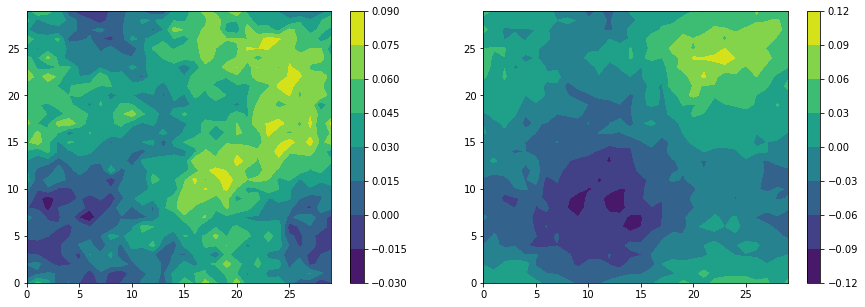

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.contourf(weights[7,0])
plt.colorbar()
plt.subplot(122)
plt.contourf(weights[7,1])
plt.colorbar()

In [5]:
def ising2dCouplings(BM,size=20,beta1=0.39,beta2=0.39,PBC=False):
    
    BM.layer.couplings =  beta1*(np.eye(N=size**2,k=1) + np.eye(N=size**2,k=-1)) + beta2*(np.eye(N=size**2,k=size) + np.eye(N=size**2,k=-size))
    
    N = size
    
    if PBC is True:
        # Add the couplings of the first row to that of the last row and vice versa:
        for i in np.arange(0,N):
            BM.layer.couplings[i,(size**2)-N+i] = beta2
            BM.layer.couplings[(size**2)-N+i,i] = beta2
        # Remove the couplings of the left most coloumn to that of the last coloumn in its previous row:
        for i in np.arange(0,N*N,N):
            BM.layer.couplings[i,i-1] = 0
            BM.layer.couplings[i-1,i] = 0
        # Add the couplings of the left most column to the right most coloumn:
            BM.layer.couplings[i,i+N-1] = beta1
            BM.layer.couplings[i+N-1,i] = beta1
    
    return BM.layer.couplings

### Track the peak Centres in time (trajectory in the 2D plane):

In [ ]:
peakCentre = np.zeros((np.shape(np.array(results['W']))[1],np.shape(np.array(results['W']))[0],2))
ditchCentre = np.zeros((np.shape(np.array(results['W']))[1],np.shape(np.array(results['W']))[0],2))

for j in np.arange(np.shape(np.array(results['W']))[1]):
    for i in np.arange(np.shape(np.array(results['W']))[0]):
        peakCentre[j,i,:] = np.unravel_index(np.argmax(np.roll(np.roll(weights[j,i],0,axis=0),0,axis=1), axis=None), weights[j,i].shape)
        ditchCentre[j,i,:] = np.unravel_index(np.argmin(np.roll(np.roll(weights[j,i],0,axis=0),0,axis=1), axis=None), weights[j,i].shape)
        
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(peakCentre[0,:,0],peakCentre[0,:,1],'r.-',ditchCentre[0,:,0],ditchCentre[0,:,1],'g.-')
plt.xlim((0,20))
plt.ylim((0,20))
plt.subplot(122)
plt.plot(peakCentre[1,:,0],peakCentre[1,:,1],'r.-',ditchCentre[1,:,0],ditchCentre[1,:,1],'g.-')
plt.xlim((0,20))
plt.ylim((0,20))

In [ ]:
def PBC_corr_2D(peakCentre,size):
    
    t1 =  np.copy(peakCentre)
    
    for i in np.argwhere(abs(peakCentre[:,0]-np.roll(peakCentre[:,0],1))>size/2):
        
        if t1[int(i),0]<5:
            peakCentre[int(i):,0] += + size
        elif t1[int(i),0]>15:
            peakCentre[int(i):,0] += - size
            
    for i in np.argwhere(abs(peakCentre[:,1]-np.roll(peakCentre[:,1],1))>size/2):
        
        if t1[int(i),1]<5:
            peakCentre[int(i):,1] += + size
        elif t1[int(i),1]>15:
            peakCentre[int(i):,1] += - size
    
    return peakCentre

In [ ]:
peakCentre_PBC    = np.copy(peakCentre)
ditchCentre_PBC   = np.copy(ditchCentre)
peakCentre_PBC[0] = PBC_corr_2D(peakCentre[0],20)
peakCentre_PBC[1] = PBC_corr_2D(peakCentre[1],20)
ditchCentre_PBC[0]= PBC_corr_2D(ditchCentre[0],20)
ditchCentre_PBC[1]= PBC_corr_2D(ditchCentre[1],20)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(peakCentre_PBC[0,:,0],peakCentre_PBC[0,:,1],'r.-',ditchCentre_PBC[0,:,0],ditchCentre_PBC[0,:,1],'g.-')
#plt.xlim((0,20))
#plt.ylim((0,20))
plt.subplot(122)
plt.plot(peakCentre_PBC[1,:,0],peakCentre_PBC[1,:,1],'r.-',ditchCentre_PBC[1,:,0],ditchCentre_PBC[1,:,1],'g.-')
#plt.xlim((0,20))
#plt.ylim((0,20))

In [ ]:
#Train the model
import rbm_relu
RBM2 = rbm_relu.RBM(visible = 'Spin', n_v=N, n_h = 2, hidden = 'ReLU',zero_field = False)
results2 = RBM2.fit(data,n_iter=100,verbose=0,learning_rate = 0.01,record=['W'],record_interval=1000,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False);

In [ ]:
# Reshape the weights array:
weights2 = np.zeros((np.shape(np.array(results2['W']))[1],np.shape(np.array(results2['W']))[0],size,size))
weights2[0] = np.reshape(np.array(results2['W'])[:,0,:],(np.shape(np.array(results2['W']))[0],size,size),order='C')
weights2[1] = np.reshape(np.array(results2['W'])[:,1,:],(np.shape(np.array(results2['W']))[0],size,size),order='C')

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.contourf(weights2[0,-1])
plt.colorbar()
plt.subplot(122)
plt.contourf(weights2[1,-1])
plt.colorbar()